# Кластеризация. Домашнее задание

ДАНИЛЬЧЕНКО ВАДИМ

### Данные

В предложенных файлах информация с публичных слушаний Москвы по правилам землепользования и застройки (ПЗЗ). В них комментарии жителей города были застенагрофированы, проклассифицированы (за/против) и нанесены на карту. Данные предоставлены в 2 вариантах, для задания можно использовать любой:
* geo_comment.xlsx
    * **comment** - комментарий одного или списка жителей к проект
    * **multiplier** - количество авторов комментария (может быть 1, может быть список)
    * **x, y** - координаты адреса, по которому был дан определённый комментарий
    * **comment_class** - за (1) / против (-1)
* geo.xlsx - те же данные, но без текстов комментариев и по 1 голосу на строку (ранее в 1 строке могло быть **multiplier** > 1 голоса)
    * **x, y** - координаты адреса, по которому был дан определённой комментарий
    * **comment_class** - за (1) / против (-1)
    
### Обязательное задание

* визуально разделить город на районы безотносительно голосов (провести кластеризацию и вывести картинку)
* аналогично исследовать скопления голосов за и против отдельно
* *подобрать оптимальное число кластеров при помощи кода из тетрадки в конце занятия (оптимально)*
* приложить ноутбук

### Дополнительные задания
* найти наиболее активные в голосовании районы *(подсказка: DBSCAN, не плотные районы обозначены одной меткой и закрашены одним цветом, cmap='gray')*
* для тех, кто уже попробовал работу с текстом: выделить основные тематики комментариев жителей, можно использовать всю имеющуюся дополнительную информацию

-------------------------------------------------------------------------------------------------------------------------------

In [13]:
import pandas as pd
import numpy as np
import joblib

import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from tqdm import tqdm_notebook 
from sklearn.cluster import KMeans

import pymorphy2
import nltk
# nltk.download("stopwords")
from nltk.corpus import stopwords

import folium
from folium.plugins import MarkerCluster
from folium.plugins import HeatMap

from gensim.models import LdaMulticore
from gensim import corpora
import re

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth',-1)

In [3]:
data=pd.read_excel('data/geo_comment.xlsx')
data.head()

,x,y,comment_class,multiplier,comment
0,37.612416,55.777454,-1,1,"Во все разделы правил землепользования и застройки г.Москвы (текстовые части и графические схемы) необходимо внести изменения по земельному участку с кадастровым номером 77:01:0004002:188 с адресом первый Самотёчный пер., вл. 17Б (в ПЗЗ территориальная зона №2034561) и исключить из этого земельного участка часть моей общей долевой собственности - земельного участка многоквартирного дома 17А по 1-му Самотёчному пер. площадью 650,5 кв.м с точками 1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-1 с координатами: 12316.39 и 6983.68; 123224 6988.91; 12316,45 и 7009,60; 12328.04 и 7013.46;12327.73 и 7014.41; 12330.06 и 7015.18; 12330.37 и 7014.24; 12335.17 и 7015.83; 12330.82 и 7028.61; 12304.74 и 7021.28; 12302.02 и 7012.47; 12303.22 и 7005.49; 12297.24 и 7004.18; 12297ю96 и 7000.60; 12311.23 и 7003.64; 12316.39 и 6983.68. - На основании вступившего в законную силу судебного решения по делу № А40-51937/2011 от 11.06.2015 о ничтожности заключённого 18.06.2007 договора аренды земельного участка с адресными ориентирами: 1-й Самотёчный пер., вл. 17Б и кадастровым номером 77:01:0004002:188."
1,37.612416,55.777454,-1,1,"На основании вступившего в законную силу судебного решения по делу № А40-51937/2011 от 11.06.2015 о ничтожности заключённого 18.06.2007 договора аренды земельного участка с адресными ориентирами: 1-й Самотёчный пер., вл.17Б и кадастровым номером 77:01:0004002:188 - необходимо внести все соответствующие изменения и исключить мою собственность площадью 650,5 кв.м из земельного участка вл. 17Б по 1-му Самотёчному пер. По поручению собственников земельного участка МКД 17А замечания и судебные акты с координатами и поворотными точками на 16 листах прилагаю. *приложены копии решения Арбитражного суда от 11.06.2015 (находятся в материалах ПС) *приложены копии Определения ВС РФ от 01.04.2016 по делу №А40-51937/11 (находятся в материалах ПС)"
2,37.603298,55.742108,-1,1,"Внести в Проект правил землепользования и застройки г.Москвы в отнош. территории ЦАО (в отношении земельных участков по адресу: г.Москва, пер. 2-й Обыденский, кадастр. №: 77:01: 0001051:3460; кадастр. Номер: 77:01:0001051:3455) изменения предусматривающие следующие предельные параметры разрешенного строительства (в отнош. каждого из указ. земельн. уч): 1. Предельно допустимая плотность застройки надземной площади: 25000 кв.м на 1Га с учётом среднеэтажной застройки. 2. Процент застройки: процент не установлен. 3. максимальная высотность: 40 метров. (подано обращение № НПКО-Эн/16-49 от 05 декабря 2016 года на 2-х листах."
3,37.558526,55.728758,-1,1,"Учитывая социальную значимость проекта строительства детского сада, лечебного учреждения и жилого комплекса по адресу Новодевичий пр-д вл.6 стр.2 и Погодинская ул. Вл.22 стр.3 (земельный участок кад. № 77:01:0005006:1007) установить зону развития для вышеуказанного участка общей площадью наземного строительства до 26000 кв. м, высотой до 47,25 м, подземной площадью до 7000 кв.м с предельной площадью застройки до 30000 кв.м на 1 Га территории."
4,37.566431,55.731794,-1,1,"Учитывая социальную значимость проекта строительства детского сада, лечебного учреждения и жилого комплекса по адресу Новодевичий пр-д вл.6 стр.2 и Погодинская ул. Вл.22 стр.3 (земельный участок кад. № 77:01:0005006:1007) установить зону развития для вышеуказанного участка общей площадью наземного строительства до 26000 кв. м, высотой до 47,25 м, подземной площадью до 7000 кв.м с предельной площадью застройки до 30000 кв.м на 1 Га территории."


In [4]:
# объединим координаты в одно значение для каждой записи, округлив преварительно до сотых - это даст некоторое приближение'
def round_coordinates(x,y):
    return str(np.round(y,2))+' '+str(np.round(x,2))

coordinates_list=[]
for row in data.iterrows():
    coordinates_list.append(round_coordinates(row[1].x,row[1].y))

data['coordinates_cat']=coordinates_list
data['x_new']=np.round(data.x, 2)
data['y_new']=np.round(data.y, 2)
data.head()

,x,y,comment_class,multiplier,comment,coordinates_cat,x_new,y_new
0,37.612416,55.777454,-1,1,"Во все разделы правил землепользования и застройки г.Москвы (текстовые части и графические схемы) необходимо внести изменения по земельному участку с кадастровым номером 77:01:0004002:188 с адресом первый Самотёчный пер., вл. 17Б (в ПЗЗ территориальная зона №2034561) и исключить из этого земельного участка часть моей общей долевой собственности - земельного участка многоквартирного дома 17А по 1-му Самотёчному пер. площадью 650,5 кв.м с точками 1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-1 с координатами: 12316.39 и 6983.68; 123224 6988.91; 12316,45 и 7009,60; 12328.04 и 7013.46;12327.73 и 7014.41; 12330.06 и 7015.18; 12330.37 и 7014.24; 12335.17 и 7015.83; 12330.82 и 7028.61; 12304.74 и 7021.28; 12302.02 и 7012.47; 12303.22 и 7005.49; 12297.24 и 7004.18; 12297ю96 и 7000.60; 12311.23 и 7003.64; 12316.39 и 6983.68. - На основании вступившего в законную силу судебного решения по делу № А40-51937/2011 от 11.06.2015 о ничтожности заключённого 18.06.2007 договора аренды земельного участка с адресными ориентирами: 1-й Самотёчный пер., вл. 17Б и кадастровым номером 77:01:0004002:188.",55.78 37.61,37.61,55.78
1,37.612416,55.777454,-1,1,"На основании вступившего в законную силу судебного решения по делу № А40-51937/2011 от 11.06.2015 о ничтожности заключённого 18.06.2007 договора аренды земельного участка с адресными ориентирами: 1-й Самотёчный пер., вл.17Б и кадастровым номером 77:01:0004002:188 - необходимо внести все соответствующие изменения и исключить мою собственность площадью 650,5 кв.м из земельного участка вл. 17Б по 1-му Самотёчному пер. По поручению собственников земельного участка МКД 17А замечания и судебные акты с координатами и поворотными точками на 16 листах прилагаю. *приложены копии решения Арбитражного суда от 11.06.2015 (находятся в материалах ПС) *приложены копии Определения ВС РФ от 01.04.2016 по делу №А40-51937/11 (находятся в материалах ПС)",55.78 37.61,37.61,55.78
2,37.603298,55.742108,-1,1,"Внести в Проект правил землепользования и застройки г.Москвы в отнош. территории ЦАО (в отношении земельных участков по адресу: г.Москва, пер. 2-й Обыденский, кадастр. №: 77:01: 0001051:3460; кадастр. Номер: 77:01:0001051:3455) изменения предусматривающие следующие предельные параметры разрешенного строительства (в отнош. каждого из указ. земельн. уч): 1. Предельно допустимая плотность застройки надземной площади: 25000 кв.м на 1Га с учётом среднеэтажной застройки. 2. Процент застройки: процент не установлен. 3. максимальная высотность: 40 метров. (подано обращение № НПКО-Эн/16-49 от 05 декабря 2016 года на 2-х листах.",55.74 37.6,37.60,55.74
3,37.558526,55.728758,-1,1,"Учитывая социальную значимость проекта строительства детского сада, лечебного учреждения и жилого комплекса по адресу Новодевичий пр-д вл.6 стр.2 и Погодинская ул. Вл.22 стр.3 (земельный участок кад. № 77:01:0005006:1007) установить зону развития для вышеуказанного участка общей площадью наземного строительства до 26000 кв. м, высотой до 47,25 м, подземной площадью до 7000 кв.м с предельной площадью застройки до 30000 кв.м на 1 Га территории.",55.73 37.56,37.56,55.73
4,37.566431,55.731794,-1,1,"Учитывая социальную значимость проекта строительства детского сада, лечебного учреждения и жилого комплекса по адресу Новодевичий пр-д вл.6 стр.2 и Погодинская ул. Вл.22 стр.3 (земельный участок кад. № 77:01:0005006:1007) установить зону развития для вышеуказанного участка общей площадью наземного строительства до 26000 кв. м, высотой до 47,25 м, подземной площадью до 7000 кв.м с предельной площадью застройки до 30000 кв.м на 1 Га территории.",55.73 37.57,37.57,55.73


In [8]:
X=data[['x_new', 'y_new']]

In [9]:
from sklearn.preprocessing import StandardScaler
X_sc=StandardScaler().fit_transform(X)
X_sc[:5]

array([[ 0.15700302, -0.08440398],
       [ 0.15700302, -0.08440398],
       [ 0.08539782, -0.69141576],
       [-0.20102299, -0.8431687 ],
       [-0.12941779, -0.8431687 ]])

In [78]:
%%time
from sklearn.cluster import KMeans
labels=[]
inertia=[]
scores=[]
for n in range(2, 15, 1):
    kmeans=KMeans(n_clusters=n, n_jobs=-1, max_iter=100, random_state=102)
    label=kmeans.fit_predict(X_sc)
    score=silhouette_score(X_sc, labels=label)
    labels.append(len(set(label)))
    scores.append(score)
    inertia.append(kmeans.inertia_)
    print(f'n_clusters:{n}, inertia: {kmeans.inertia_}, score: {score}')    

n_clusters:2, inertia: 58372.14764234644, score: 0.5468613197895293
n_clusters:3, inertia: 35572.831382621654, score: 0.5364632379275294
n_clusters:4, inertia: 26709.23614095607, score: 0.54995221860595
n_clusters:5, inertia: 19112.51251636599, score: 0.5630286186936544
n_clusters:6, inertia: 14789.486077749143, score: 0.5695246444479507
n_clusters:7, inertia: 10806.917014364935, score: 0.605227363409524
n_clusters:8, inertia: 9209.117648721569, score: 0.6196499283566951
n_clusters:9, inertia: 8038.568026086145, score: 0.6231513792191362
n_clusters:10, inertia: 7136.901432089869, score: 0.5982588194067997
n_clusters:11, inertia: 6298.540659056587, score: 0.6035492733419092
n_clusters:12, inertia: 5565.844006983133, score: 0.607382451938392
n_clusters:13, inertia: 5278.276064843539, score: 0.5868951522868538
n_clusters:14, inertia: 4709.40487952745, score: 0.6281576317840796
Wall time: 25min 11s


In [80]:
print(f'best inertia {range(2, 15, 1)[np.argmax(inertia)]}')
print(f'best silhouette score {range(2, 15, 1)[np.argmax(scores)]}')

best inertia 2
best silhouette score 14


довольно неоднозначно, посмотрим на график убывания квадрата расстояний до центроидов кластера при разном количестве кластеров

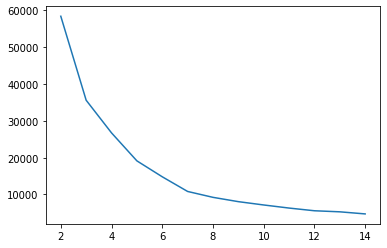

In [81]:
plt.plot(range(2, 15, 1), inertia)

кажется после 7 кластеров убывание показателя становится не таким резким, 

чтобы убедиться, посчитаем метрику - отношение прироста параметра за текущий период по отношению к приросту предыдущего

$$k_{opt} = argmin(\frac{inertia_{k+1}-inertia_{k}}{inertia_{k}-inertia_{k-1}})$$

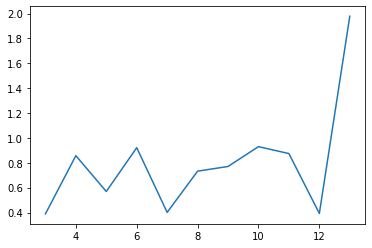

In [92]:
diff = np.diff(inertia, n=1)
k = diff[1:] / diff[:-1]
plt.plot(range(2, 15, 1)[1:-1], k)

In [96]:
np.argsort(scores)[::-1]+3

array([15, 10,  9, 13,  8, 12, 11, 14,  7,  6,  5,  3,  4], dtype=int64)

текущий график более нагляден - мы видим все изменения темпов прироста - в данном случае лучшие на 3, 7 и 12 кластерах, но по первому графику можно сказать, что 7 более нам подходит, к тому же silhouette при этом довольно хороший 

In [10]:
%%time
# построим модель на найденных параметрах
kmeans=KMeans(n_clusters=7, n_jobs=-1, max_iter=100, random_state=102)
kmeans.fit_predict(X_sc)

Wall time: 3.06 s


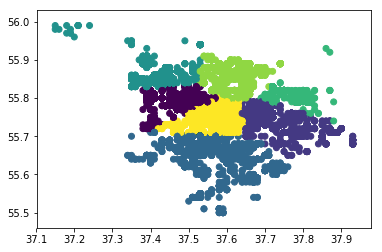

In [12]:
plt.scatter(data.x_new, data.y_new, c=kmeans.labels_)

In [40]:
# перенесем кластеры на карту
data['clusters_kmeans']=kmeans.labels_

map = folium.Map(location=[55.753627, 37.621431], zoom_start=10, control_scale=True, prefer_canvas=True, tiles='Stamen Toner')

cluster = MarkerCluster()

for row in data.iterrows():
    cluster.add_child(folium.Marker(location=[row[1]['y_new'], row[1]['x_new']], popup=row[1].clusters_kmeans))
    
map.add_child(cluster)

map.save('clusters_map.html')

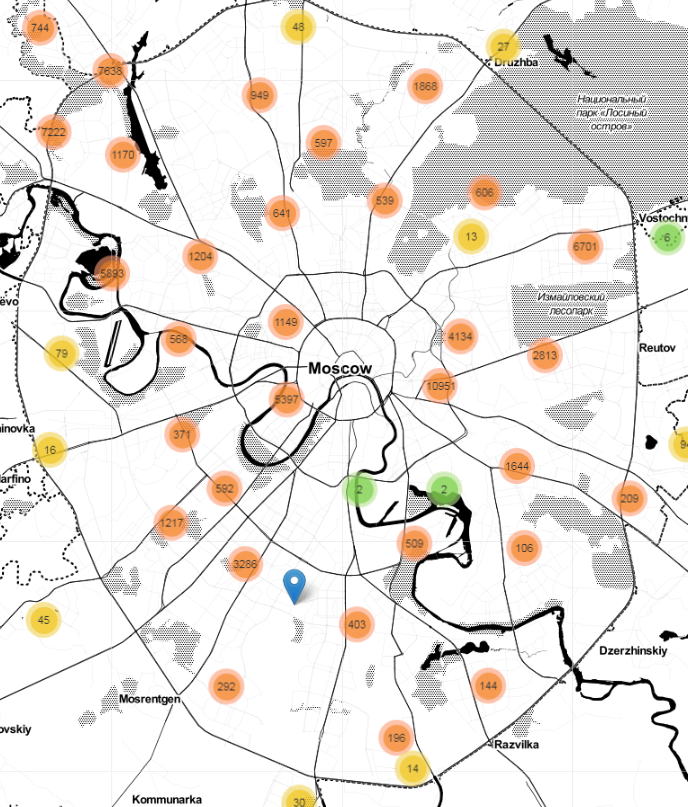

In [44]:
from IPython.display import Image
Image('data/карта в сером цвете.PNG')

покажем также инетрактивную тепловую карту (мне очень понравилась :) )

In [ ]:
points_array = data[['y_new', 'x_new']].values

m = folium.Map(location=[55.753627, 37.621431], tiles = 'stamentoner', zoom_start=10, control_scale=True)
m.add_child(HeatMap(points_array, radius=15))

# Show map
map.save('heatmap.html')

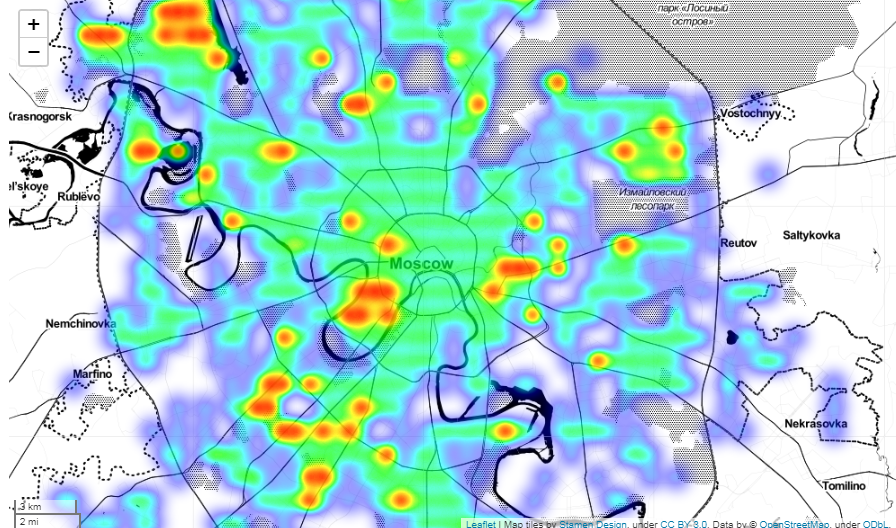

In [47]:
# если не отобразится карта
Image('data/тепловая карта.PNG')

### посмотрим на активность горожан

In [57]:
%%time
# сделаем кластеризацию на полученных данных
epsylon=np.arange(0.1,1,0.1)
samples=np.arange(4,10,1)

scores=[]
labels=[]
metrics=[]
for i in tqdm_notebook(epsylon):
    for j in samples:
        dbscan=DBSCAN(eps=i, min_samples=j, n_jobs=20)
        dbscan.fit_predict(X_sc)
        temp_score=silhouette_score(X_sc, labels=dbscan.labels_)
        temp_labels=dbscan.labels_
        print(f'eps:{i}, n_samples: {j}, score: {temp_score}, n_clusters: {len(set(temp_labels))}')            
        scores.append(temp_score)
        labels.append(len(set(temp_labels)))  
        metrics.append(f'e_{i}, n_{j}')

eps:0.1, n_samples: 4, score: 0.6431624444190686, n_clusters: 192
eps:0.1, n_samples: 5, score: 0.6432838568175088, n_clusters: 186
eps:0.1, n_samples: 6, score: 0.6596467549913015, n_clusters: 173
eps:0.1, n_samples: 7, score: 0.6609414923242868, n_clusters: 171
eps:0.1, n_samples: 8, score: 0.6607893773043122, n_clusters: 170
eps:0.1, n_samples: 9, score: 0.6599036937759407, n_clusters: 166
eps:0.2, n_samples: 4, score: -0.2793550498728335, n_clusters: 14
eps:0.2, n_samples: 5, score: -0.21669173789588023, n_clusters: 13
eps:0.2, n_samples: 6, score: -0.21680214173182316, n_clusters: 12
eps:0.2, n_samples: 7, score: -0.16607209640348883, n_clusters: 9
eps:0.2, n_samples: 8, score: -0.20633827264661986, n_clusters: 12
eps:0.2, n_samples: 9, score: -0.20621593336801589, n_clusters: 11
eps:0.30000000000000004, n_samples: 4, score: -0.010490404930505105, n_clusters: 8
eps:0.30000000000000004, n_samples: 5, score: -0.010490404930505105, n_clusters: 8
eps:0.30000000000000004, n_samples: 6,

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


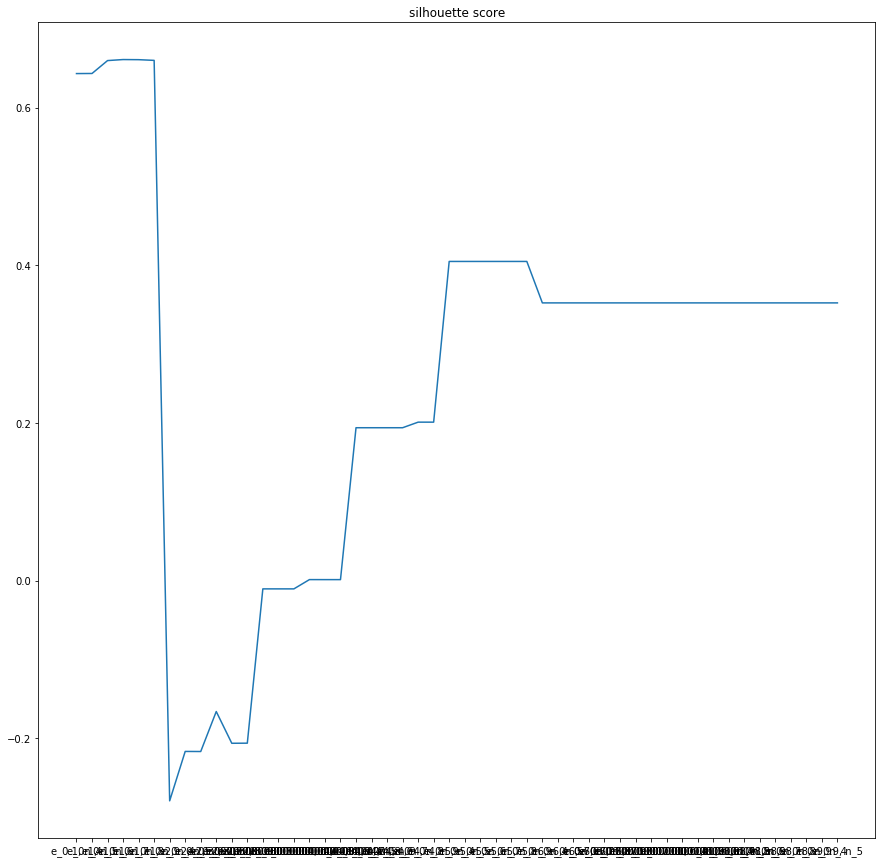

In [59]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(15,15))
plt.title('silhouette score')
plt.plot(metrics, scores)

In [63]:
print(f'max: {max(scores)} при параметрах: {metrics[np.argmax(scores)]}, кластеров {labels[np.argmax(scores)]}')

max: 0.6609414923242868 при параметрах: e_0.1, n_7, кластеров 171


при eps=0.1, было достигнуто максимальное значение метрики

In [64]:
# построим модель по рассчитанным параметрам
dbscan=DBSCAN(eps=0.1, min_samples=7, n_jobs=20, metric='euclidean')
labels=dbscan.fit_predict(X_sc)
len(set(labels))

171

In [65]:
# объединим метку кластера с исходными данными
data['clusters']=labels
data.head(3)

,x,y,comment_class,multiplier,comment,coordinates_cat,x_new,y_new,clusters
0,37.612416,55.777454,-1,1,"Во все разделы правил землепользования и застройки г.Москвы (текстовые части и графические схемы) необходимо внести изменения по земельному участку с кадастровым номером 77:01:0004002:188 с адресом первый Самотёчный пер., вл. 17Б (в ПЗЗ территориальная зона №2034561) и исключить из этого земельного участка часть моей общей долевой собственности - земельного участка многоквартирного дома 17А по 1-му Самотёчному пер. площадью 650,5 кв.м с точками 1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-1 с координатами: 12316.39 и 6983.68; 123224 6988.91; 12316,45 и 7009,60; 12328.04 и 7013.46;12327.73 и 7014.41; 12330.06 и 7015.18; 12330.37 и 7014.24; 12335.17 и 7015.83; 12330.82 и 7028.61; 12304.74 и 7021.28; 12302.02 и 7012.47; 12303.22 и 7005.49; 12297.24 и 7004.18; 12297ю96 и 7000.60; 12311.23 и 7003.64; 12316.39 и 6983.68. - На основании вступившего в законную силу судебного решения по делу № А40-51937/2011 от 11.06.2015 о ничтожности заключённого 18.06.2007 договора аренды земельного участка с адресными ориентирами: 1-й Самотёчный пер., вл. 17Б и кадастровым номером 77:01:0004002:188.",55.78 37.61,37.61,55.78,0
1,37.612416,55.777454,-1,1,"На основании вступившего в законную силу судебного решения по делу № А40-51937/2011 от 11.06.2015 о ничтожности заключённого 18.06.2007 договора аренды земельного участка с адресными ориентирами: 1-й Самотёчный пер., вл.17Б и кадастровым номером 77:01:0004002:188 - необходимо внести все соответствующие изменения и исключить мою собственность площадью 650,5 кв.м из земельного участка вл. 17Б по 1-му Самотёчному пер. По поручению собственников земельного участка МКД 17А замечания и судебные акты с координатами и поворотными точками на 16 листах прилагаю. *приложены копии решения Арбитражного суда от 11.06.2015 (находятся в материалах ПС) *приложены копии Определения ВС РФ от 01.04.2016 по делу №А40-51937/11 (находятся в материалах ПС)",55.78 37.61,37.61,55.78,0
2,37.603298,55.742108,-1,1,"Внести в Проект правил землепользования и застройки г.Москвы в отнош. территории ЦАО (в отношении земельных участков по адресу: г.Москва, пер. 2-й Обыденский, кадастр. №: 77:01: 0001051:3460; кадастр. Номер: 77:01:0001051:3455) изменения предусматривающие следующие предельные параметры разрешенного строительства (в отнош. каждого из указ. земельн. уч): 1. Предельно допустимая плотность застройки надземной площади: 25000 кв.м на 1Га с учётом среднеэтажной застройки. 2. Процент застройки: процент не установлен. 3. максимальная высотность: 40 метров. (подано обращение № НПКО-Эн/16-49 от 05 декабря 2016 года на 2-х листах.",55.74 37.6,37.60,55.74,1


In [71]:
# сохраним результаты кластеризации
joblib.dump(data, 'data/data_clusters')

['data/data_clusters']

In [2]:
# загрузим данные
data=joblib.load('data/data_clusters')
data.head()

,x,y,comment_class,multiplier,comment,coordinates_cat,x_new,y_new,clusters
0,37.612416,55.777454,-1,1,"Во все разделы правил землепользования и застройки г.Москвы (текстовые части и графические схемы) необходимо внести изменения по земельному участку с кадастровым номером 77:01:0004002:188 с адресом первый Самотёчный пер., вл. 17Б (в ПЗЗ территориальная зона №2034561) и исключить из этого земельного участка часть моей общей долевой собственности - земельного участка многоквартирного дома 17А по 1-му Самотёчному пер. площадью 650,5 кв.м с точками 1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-1 с координатами: 12316.39 и 6983.68; 123224 6988.91; 12316,45 и 7009,60; 12328.04 и 7013.46;12327.73 и 7014.41; 12330.06 и 7015.18; 12330.37 и 7014.24; 12335.17 и 7015.83; 12330.82 и 7028.61; 12304.74 и 7021.28; 12302.02 и 7012.47; 12303.22 и 7005.49; 12297.24 и 7004.18; 12297ю96 и 7000.60; 12311.23 и 7003.64; 12316.39 и 6983.68. - На основании вступившего в законную силу судебного решения по делу № А40-51937/2011 от 11.06.2015 о ничтожности заключённого 18.06.2007 договора аренды земельного участка с адресными ориентирами: 1-й Самотёчный пер., вл. 17Б и кадастровым номером 77:01:0004002:188.",55.78 37.61,37.61,55.78,0
1,37.612416,55.777454,-1,1,"На основании вступившего в законную силу судебного решения по делу № А40-51937/2011 от 11.06.2015 о ничтожности заключённого 18.06.2007 договора аренды земельного участка с адресными ориентирами: 1-й Самотёчный пер., вл.17Б и кадастровым номером 77:01:0004002:188 - необходимо внести все соответствующие изменения и исключить мою собственность площадью 650,5 кв.м из земельного участка вл. 17Б по 1-му Самотёчному пер. По поручению собственников земельного участка МКД 17А замечания и судебные акты с координатами и поворотными точками на 16 листах прилагаю. *приложены копии решения Арбитражного суда от 11.06.2015 (находятся в материалах ПС) *приложены копии Определения ВС РФ от 01.04.2016 по делу №А40-51937/11 (находятся в материалах ПС)",55.78 37.61,37.61,55.78,0
2,37.603298,55.742108,-1,1,"Внести в Проект правил землепользования и застройки г.Москвы в отнош. территории ЦАО (в отношении земельных участков по адресу: г.Москва, пер. 2-й Обыденский, кадастр. №: 77:01: 0001051:3460; кадастр. Номер: 77:01:0001051:3455) изменения предусматривающие следующие предельные параметры разрешенного строительства (в отнош. каждого из указ. земельн. уч): 1. Предельно допустимая плотность застройки надземной площади: 25000 кв.м на 1Га с учётом среднеэтажной застройки. 2. Процент застройки: процент не установлен. 3. максимальная высотность: 40 метров. (подано обращение № НПКО-Эн/16-49 от 05 декабря 2016 года на 2-х листах.",55.74 37.6,37.60,55.74,1
3,37.558526,55.728758,-1,1,"Учитывая социальную значимость проекта строительства детского сада, лечебного учреждения и жилого комплекса по адресу Новодевичий пр-д вл.6 стр.2 и Погодинская ул. Вл.22 стр.3 (земельный участок кад. № 77:01:0005006:1007) установить зону развития для вышеуказанного участка общей площадью наземного строительства до 26000 кв. м, высотой до 47,25 м, подземной площадью до 7000 кв.м с предельной площадью застройки до 30000 кв.м на 1 Га территории.",55.73 37.56,37.56,55.73,2
4,37.566431,55.731794,-1,1,"Учитывая социальную значимость проекта строительства детского сада, лечебного учреждения и жилого комплекса по адресу Новодевичий пр-д вл.6 стр.2 и Погодинская ул. Вл.22 стр.3 (земельный участок кад. № 77:01:0005006:1007) установить зону развития для вышеуказанного участка общей площадью наземного строительства до 26000 кв. м, высотой до 47,25 м, подземной площадью до 7000 кв.м с предельной площадью застройки до 30000 кв.м на 1 Га территории.",55.73 37.57,37.57,55.73,2


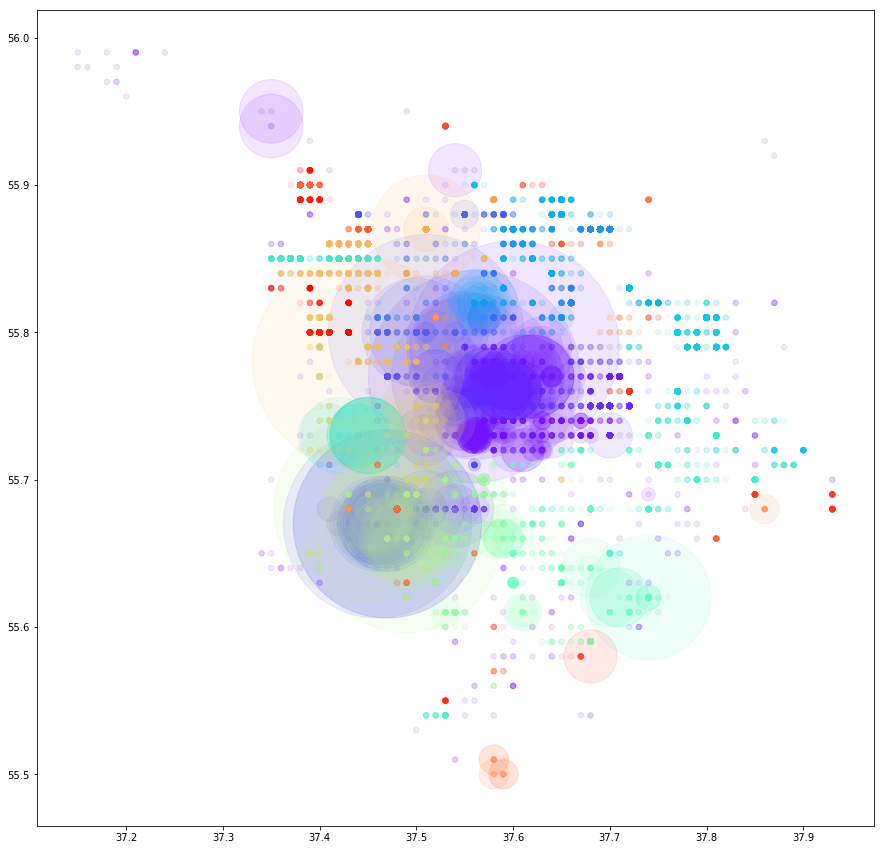

In [69]:
# посмотрим где больше всего 
import matplotlib.cm as cm
plt.figure(figsize=(15, 15))
alpha = 0.1
gs = data.groupby(['clusters'])
cs = cm.rainbow(np.linspace(0, 1, len(set(labels))))
for g, c in zip(gs, cs):
    plt.scatter(g[1].x_new, g[1].y_new, s=g[1].multiplier*30, color=c, alpha=alpha)
plt.show()

Центр сильно отличается по активности в голосовании 

посмотрим отдельно на за и против, возможно районы отличаются

<BarContainer object of 2 artists>

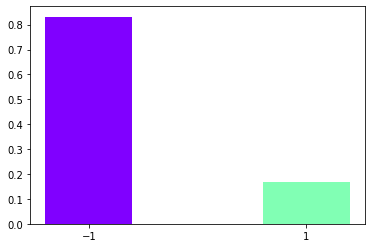

In [49]:
plt.xticks(data.comment_class.unique())
colors=cm.rainbow(np.arange(0, 2, 0.5))
plt.bar(data.comment_class.unique(), data.comment_class.value_counts(normalize=True), color=colors)

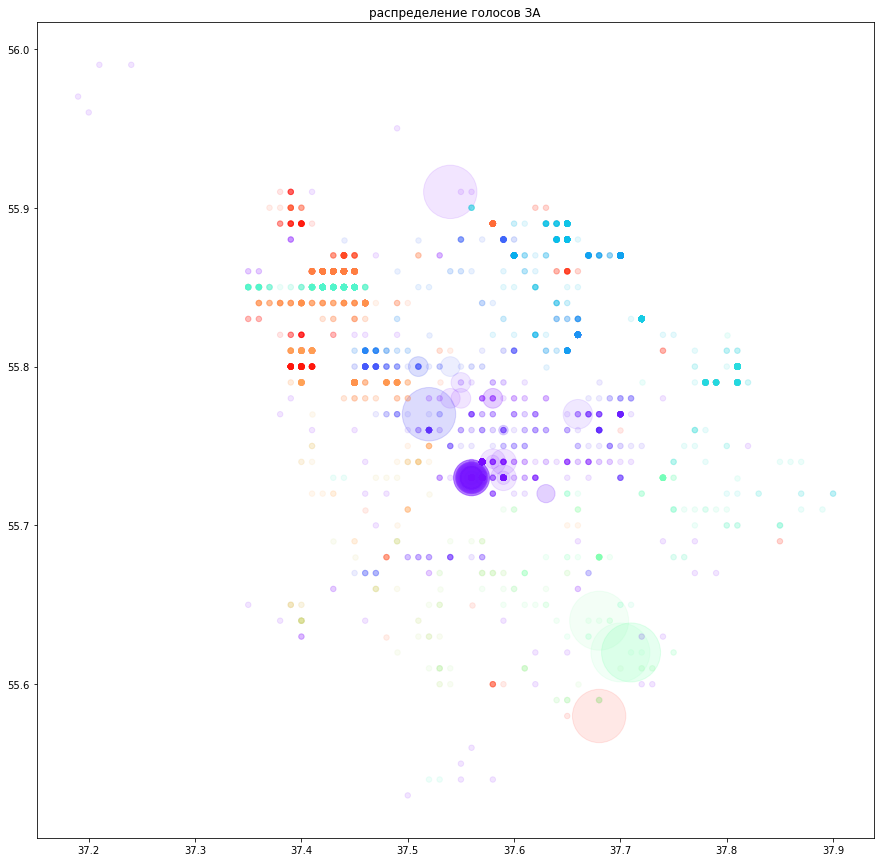

In [18]:
# посмотрим где больше всего голосов ЗА (comment_class==1)
import matplotlib.cm as cm
plt.figure(figsize=(15, 15))
alpha = 0.1
gs = data[data.comment_class==1].groupby(['clusters'])
cs = cm.rainbow(np.linspace(0, 1, len(gs)))
plt.title('распределение голосов ЗА')
for g, c in zip(gs, cs):
    plt.scatter(g[1].x_new, g[1].y_new, s=g[1].multiplier*30, color=c, alpha=alpha)
plt.show()

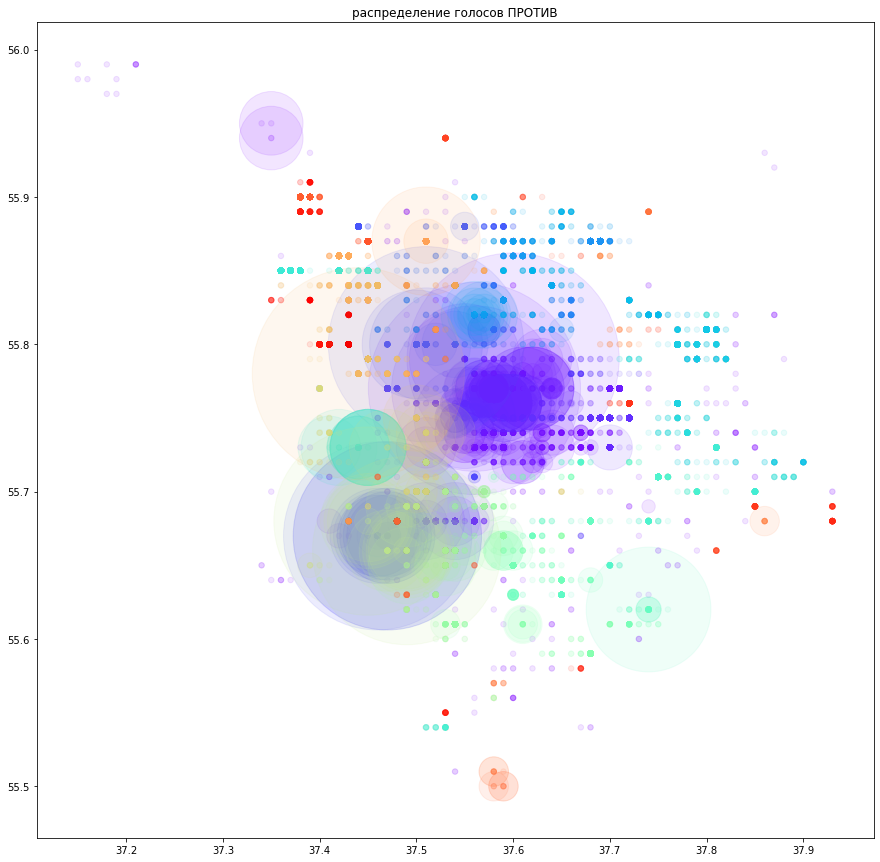

In [21]:
# посмотрим где больше всего голосов ПРОТИВ (comment_class==-1)
import matplotlib.cm as cm
plt.figure(figsize=(15, 15))
alpha = 0.1
gs = data[data.comment_class==-1].groupby(['clusters'])
cs = cm.rainbow(np.linspace(0, 1, len(gs)))
plt.title('распределение голосов ПРОТИВ')
for g, c in zip(gs, cs):
    plt.scatter(g[1].x_new, g[1].y_new, s=g[1].multiplier*30, color=c, alpha=alpha)
plt.show()

видим, что ПРОТИВ в несколько раз больше ЗА, также из наблюдений большие вспышки количества заявлений ПРОТИВ в центре, и немного отличающиеся на общем фоне ЗА на юго-востоке 

### посмотрим на тематики сообщений

In [34]:
morph = pymorphy2.MorphAnalyzer()

# подгрузим стоп-слова
try:
    russian_stopwords = stopwords.words("russian")
except:
    russian_stopwords=joblib.load('data/russian_stopwords')

errors=joblib.load('data/errors2correct_dict.pkl')    
    
def preprocess_text(text):
    text = str(text).lower().strip()
    text = text.replace("ё", "е")
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'URL', text)
    text = re.sub('@[^\s]+', 'USER', text)
    text = re.sub('[^a-zA-Zа-яА-Я1-9]+', ' ', text) 
    text = re.sub(' +', ' ', text)
    text = re.sub(r'[^\w\s]+|[\d]+', ' ',text)
    
    if len(text)==1:
        tokens = text.strip()
    else:
        tokens = text.split()

    tokens_result=[]
    
    for token in tokens:
        if len(token.strip())>0 and token.strip() not in russian_stopwords:
            token=morph.parse(token.strip())[0].normal_form
            if token in errors.keys():
                tokens_result.append(errors[token])
            else:
                tokens_result.append(token)
            
#               and token.strip() not in punctuation]
    
    return " ".join(tokens_result)

In [35]:
%%time
sentences_list=[preprocess_text(sentence).split() for sentence in data.comment]

CPU times: user 10min 45s, sys: 6.05 s, total: 10min 51s
Wall time: 10min 51s


In [36]:
%%time
dictionary=corpora.Dictionary(sentences_list)
corpus=[dictionary.doc2bow(word) for word in sentences_list]

CPU times: user 31.8 s, sys: 2.73 s, total: 34.5 s
Wall time: 34.5 s


In [39]:
%%time
# поставим 50 тем
LDA=LdaMulticore(workers=20, 
                 num_topics=5, 
                 corpus=corpus,
                id2word=dictionary
                )

CPU times: user 6.38 s, sys: 6.16 s, total: 12.5 s
Wall time: 12.7 s


In [40]:
# прочитаем топ 10 тематик обращений
LDA.show_topics()

[(0,
  '0.019*"проект" + 0.019*"территория" + 0.017*"москва" + 0.016*"земельный" + 0.015*"застройка" + 0.014*"участок" + 0.014*"год" + 0.013*"зона" + 0.012*"использование" + 0.012*"пзз"'),
 (1,
  '0.023*"участок" + 0.019*"проект" + 0.018*"москва" + 0.016*"застройка" + 0.015*"строительство" + 0.014*"земельный" + 0.013*"зона" + 0.011*"город" + 0.011*"объект" + 0.009*"пзз"'),
 (2,
  '0.024*"застройка" + 0.019*"проект" + 0.016*"участок" + 0.015*"территория" + 0.015*"москва" + 0.013*"объект" + 0.012*"зона" + 0.011*"земельный" + 0.011*"год" + 0.010*"использование"'),
 (3,
  '0.019*"застройка" + 0.019*"зона" + 0.017*"москва" + 0.015*"проект" + 0.014*"участок" + 0.014*"объект" + 0.013*"территория" + 0.011*"год" + 0.011*"город" + 0.010*"земельный"'),
 (4,
  '0.025*"москва" + 0.024*"проект" + 0.014*"участок" + 0.014*"застройка" + 0.014*"территория" + 0.013*"зона" + 0.012*"земельный" + 0.012*"строительство" + 0.011*"объект" + 0.011*"город"')]

### в общем что при 50 темах, что при 5 везде одно и то же - объекты застройки в Москве (было бы удивительно, если это было бы не так, учитывая, что априори мы скормили алгоритму данные с публичных слушаний Москвы по правилам землепользования и застройки :) )